# Face Extraction 

In [1]:
#default_exp nb_01a

In [2]:
#export
from fastai.vision import *
from kgl_deepfake.nb_00 import *
from IPython.display import HTML
import cv2
from tqdm import tqdm
from facenet_pytorch import MTCNN
from nbdev.export import *

### Data

In [3]:
SOURCE = Path('../data/train_sample_videos/')

In [4]:
f = get_files(SOURCE, extensions=['.json'])[0]
annots = pd.read_json(f).T

In [5]:
sr, sf = annots[annots.label=='REAL'].sample(8), annots[annots.label=='FAKE'].sample(8)
s = sr.append(sf)

In [6]:
s['fname'] = pd.Series(s.index).apply(lambda o: SOURCE/o).values
s = s.sample(s.shape[0])

In [7]:
s.head()

,label,split,original,fname
ddepeddixj.mp4,REAL,train,None,../data/train_sample_videos/ddepeddixj.mp4
dfbpceeaox.mp4,FAKE,train,bffwsjxghk.mp4,../data/train_sample_videos/dfbpceeaox.mp4
axntxmycwd.mp4,REAL,train,None,../data/train_sample_videos/axntxmycwd.mp4
eqnoqyfquo.mp4,REAL,train,None,../data/train_sample_videos/eqnoqyfquo.mp4
altziddtxi.mp4,FAKE,train,meawmsgiti.mp4,../data/train_sample_videos/altziddtxi.mp4


### Image resizing

In [8]:
vid_nbr = 3

In [9]:
fname = str(s.fname[vid_nbr])
fname

'../data/train_sample_videos/eqnoqyfquo.mp4'

In [10]:
HTML(html_vid(fname))

In [11]:
capture = cv2.VideoCapture(fname)
_, img = capture.read()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
capture.release()

(1080, 1920, 3)

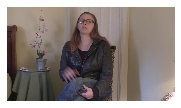

In [17]:
Image(tensor(img).permute(2, 0, 1)).show(); img.shape

Resize by specifying fractional width and height of the image, because some images are portrait and some are landscape.  In addition to the original size, we might also consider $\times 1/1.5$ and $\times 1/2$ the original lengths.

[opencv resize](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=resize#resize)

In [22]:
img_medium = cv2.resize(img, (0, 0), fx=.5, fy=.5)

(540, 960, 3)

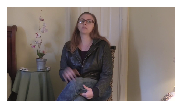

In [27]:
Image(tensor(img_medium).permute(2, 0, 1)).show(); img_medium.shape

### Get frames from video

Here's how to extract frames of different sizes from a video using `cv2`.

In [28]:
#export
def video2frames(fname, *fs):
    '''
    fname - path to mp4 file
    fs - fractional lengths to resize original image to. e.g. (.5, .25)
    '''
    capture = cv2.VideoCapture(fname)
    imgs = []
    for i in tqdm(range(int(capture.get(cv2.CAP_PROP_FRAME_COUNT)))):
        _, img0 = capture.read()
        img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
        imgs.append([img0] + [cv2.resize(img0, (0, 0), fx=f, fy=f) for f in fs])
    capture.release()
    return [np.stack(imgsz) for imgsz in zip(*imgs)]

In [29]:
%%time
frames = video2frames(fname, 1/1.5, 1/2)

100%|██████████| 300/300 [00:03<00:00, 93.83it/s]


CPU times: user 17 s, sys: 2.75 s, total: 19.8 s
Wall time: 3.91 s


In [30]:
frames[0].shape, frames[1].shape, frames[2].shape

((300, 1080, 1920, 3), (300, 720, 1280, 3), (300, 540, 960, 3))

In [31]:
def plot_faces(images, figsize=(10.8/2, 19.2/2)):
    shape = images[0].shape
    images = images[np.linspace(0, len(images)-1, 16).astype(int)]
    im_plot = []
    for i in range(0, 16, 4):
        im_plot.append(np.concatenate(images[i:i+4], axis=0))
    im_plot = np.concatenate(im_plot, axis=1)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(im_plot)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    ax.grid(False)
    fig.tight_layout()

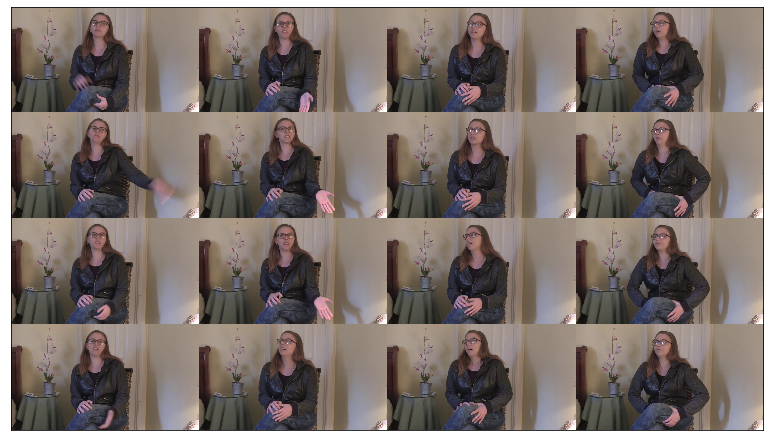

In [32]:
plot_faces(frames[2], figsize=(10.8, 19.2))

### `facenet-pytorch` face extraction

Since it's been reported that `facenet-pytorch` is the fastest at extracting faces from images, we will use it and define some functions for this purpose here.

In [33]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [34]:
detector = MTCNN(device=device, post_process=False)

In [35]:
#export
def detect_facenet_pytorch(detector, images, batch_size):
    '''
    detector - facenet_pytorch.MTCNN
    images:  numpy.array
      array of images
    batch_size: int
      Number of images to be processed by `detector` in one go.
    '''
    faces = []
    for lb in np.arange(0, len(images), batch_size):
        imgs_pil = [PIL.Image.fromarray(image) for image in images[lb:lb+batch_size]]
        faces.extend(detector(imgs_pil))
    return torch.stack(faces)

Test on the small-sized frames, `frames[2]`, and only the first 100 of them.

In [36]:
%%time 
faces = detect_facenet_pytorch(detector, frames[2][:100], 32)

CPU times: user 1.78 s, sys: 264 ms, total: 2.05 s
Wall time: 2.61 s


All returned face images have the same dimension, regardless of the frame they come from.

In [37]:
faces.shape, faces.dtype

(torch.Size([100, 3, 160, 160]), torch.float32)

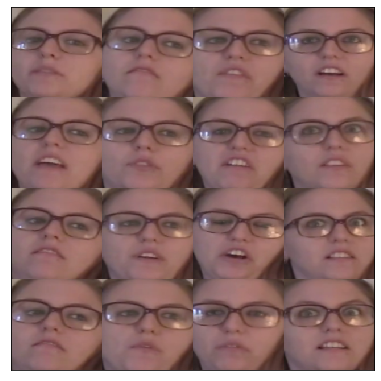

In [38]:
plot_faces(faces.permute(0, 2, 3, 1).int().numpy())

### Saving face images

In [39]:
DIR_FACES = Path('../data/train_sample_faces/')

In [40]:
os.makedirs(DIR_FACES, exist_ok=True)

In [41]:
r = s.iloc[vid_nbr]
r

label                                             REAL
split                                            train
original                                          None
fname       ../data/train_sample_videos/eqnoqyfquo.mp4
Name: eqnoqyfquo.mp4, dtype: object

In [42]:
type(r.fname)

pathlib.PosixPath

In [49]:
idxs = [0, 16, 32, 34, 45, 87, 19]

In [50]:
save_paths = [DIR_FACES/f'{r.fname.stem}_{i}_{r.label}.png' for i in idxs]
save_paths = [str(o) for o in save_paths]
save_paths

['../data/train_sample_faces/eqnoqyfquo_0_REAL.png',
 '../data/train_sample_faces/eqnoqyfquo_16_REAL.png',
 '../data/train_sample_faces/eqnoqyfquo_32_REAL.png',
 '../data/train_sample_faces/eqnoqyfquo_34_REAL.png',
 '../data/train_sample_faces/eqnoqyfquo_45_REAL.png',
 '../data/train_sample_faces/eqnoqyfquo_87_REAL.png',
 '../data/train_sample_faces/eqnoqyfquo_19_REAL.png']

In [51]:
frames[2][idxs].shape

(7, 540, 960, 3)

In [52]:
pilimgs = [PIL.Image.fromarray(f) for f in frames[2][idxs]]

In [53]:
_ = detector(pilimgs, save_path=save_paths)

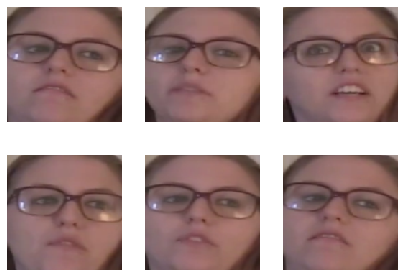

In [54]:
imgs = (open_image(o) for o in get_image_files(DIR_FACES))
def _func(i, j): return next(imgs)
show_multi(_func, 2, 3, figsize=(7, 5))

In [56]:
for o in DIR_FACES.ls(): os.remove(o)

### Fast pipeline

The following class puts together:
1. Frame extraction
2. Frame resizing
3. Face extraction

https://www.kaggle.com/unkownhihi/starter-kernel-with-cnn-model-ll-lb-0-69235

In [57]:
#export

#comes from https://www.kaggle.com/unkownhihi/starter-kernel-with-cnn-model-ll-lb-0-69235
class DetectionPipeline:
    """Pipeline class for detecting faces in the frames of a video file."""
    
    def __init__(self, detector, n_frames=None, batch_size=60, resize=None):
        """Constructor for DetectionPipeline class.
        
        Keyword Arguments:
            n_frames {int} -- Total number of frames to load. These will be evenly spaced
                throughout the video. If not specified (i.e., None), all frames will be loaded.
                (default: {None})
            batch_size {int} -- Batch size to use with MTCNN face detector. (default: {32})
            resize {float} -- Fraction by which to resize frames from original prior to face
                detection. A value less than 1 results in downsampling and a value greater than
                1 result in upsampling. (default: {None})
        """
        self.detector = detector
        self.n_frames, self.batch_size, self.resize = n_frames, batch_size, resize
    
    def __call__(self, filename, label=None, save_dir=None):
        """Load frames from an MP4 video and detect faces.
        Arguments:
            filename {str} -- Path to video.
        """
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if self.n_frames is None: sample = np.arange(0, v_len)
        else: sample = np.linspace(0, v_len - 1, self.n_frames).astype(int)

        faces = []
        idxs, frames = [], []
        for j in range(v_len):
            success = v_cap.grab()
            if j in sample:
                success, frame = v_cap.retrieve()
                if not success: continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = PIL.Image.fromarray(frame)
                
                if self.resize is not None:
                    frame = frame.resize([int(d * self.resize) for d in frame.size])
                idxs.append(j); frames.append(frame)

                if len(frames) % self.batch_size == 0 or j == sample[-1]:
                    if save_dir is not None:
                        save_paths = self.get_savepaths(filename, idxs, label, save_dir)
                        faces.extend(self.detector(frames, save_path=save_paths))
                    else: faces.extend(self.detector(frames))
                    idxs, frames = [], []

        v_cap.release()
        return torch.stack(faces)
    
    def get_savepaths(self, filename, idxs, label=None, save_dir=None):
        if isinstance(filename, str): filename = Path(filename)
        if save_dir is None: save_dir = Path('./')
        if label is None: save_paths = [save_dir/f'{filename.stem}_{i:03d}.png' for i in idxs]
        else: save_paths = [save_dir/f'{filename.stem}_{i:03d}_{label}.png' for i in idxs]
        return [str(o) for o in save_paths]        

In [58]:
detect_pipe = DetectionPipeline(detector=detector, n_frames=60, batch_size=60, resize=1/2)

In [60]:
%%time
faces = detect_pipe(fname, save_dir=DIR_FACES, label='NotReal')

CPU times: user 9.49 s, sys: 360 ms, total: 9.85 s
Wall time: 2.23 s


In [61]:
len(faces)

60

In [62]:
faces.shape

torch.Size([60, 3, 160, 160])

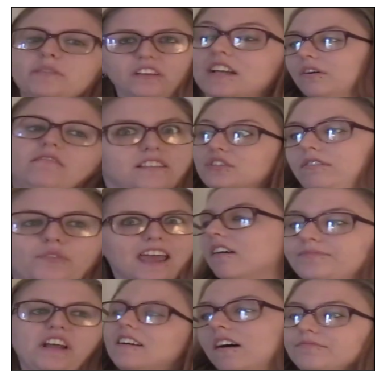

In [63]:
plot_faces(faces.permute(0, 2, 3, 1).int().numpy(),)

In [64]:
sorted([o for o in DIR_FACES.ls()])

[PosixPath('../data/train_sample_faces/eqnoqyfquo_000_NotReal.png'),
 PosixPath('../data/train_sample_faces/eqnoqyfquo_005_NotReal.png'),
 PosixPath('../data/train_sample_faces/eqnoqyfquo_010_NotReal.png'),
 PosixPath('../data/train_sample_faces/eqnoqyfquo_015_NotReal.png'),
 PosixPath('../data/train_sample_faces/eqnoqyfquo_020_NotReal.png'),
 PosixPath('../data/train_sample_faces/eqnoqyfquo_025_NotReal.png'),
 PosixPath('../data/train_sample_faces/eqnoqyfquo_030_NotReal.png'),
 PosixPath('../data/train_sample_faces/eqnoqyfquo_035_NotReal.png'),
 PosixPath('../data/train_sample_faces/eqnoqyfquo_040_NotReal.png'),
 PosixPath('../data/train_sample_faces/eqnoqyfquo_045_NotReal.png'),
 PosixPath('../data/train_sample_faces/eqnoqyfquo_050_NotReal.png'),
 PosixPath('../data/train_sample_faces/eqnoqyfquo_055_NotReal.png'),
 PosixPath('../data/train_sample_faces/eqnoqyfquo_060_NotReal.png'),
 PosixPath('../data/train_sample_faces/eqnoqyfquo_065_NotReal.png'),
 PosixPath('../data/train_sample_f

In [65]:
for o in DIR_FACES.ls(): os.remove(o)

# -fin

In [306]:
notebook2script()

Converted 00_lookatdata.ipynb.
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
Converted 01_face_recog.ipynb.
Converted 01a_face_extraction.ipynb.
Converted 02bis_Create_Dataset-Copy1.ipynb.
Converted 02bis_Create_Dataset.ipynb.
Converted 03_mesonet.ipynb.
